In [1]:
# 캘리포니아 주택 가격 데이터

import os
import tarfile
from six.moves import urllib
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [2]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()

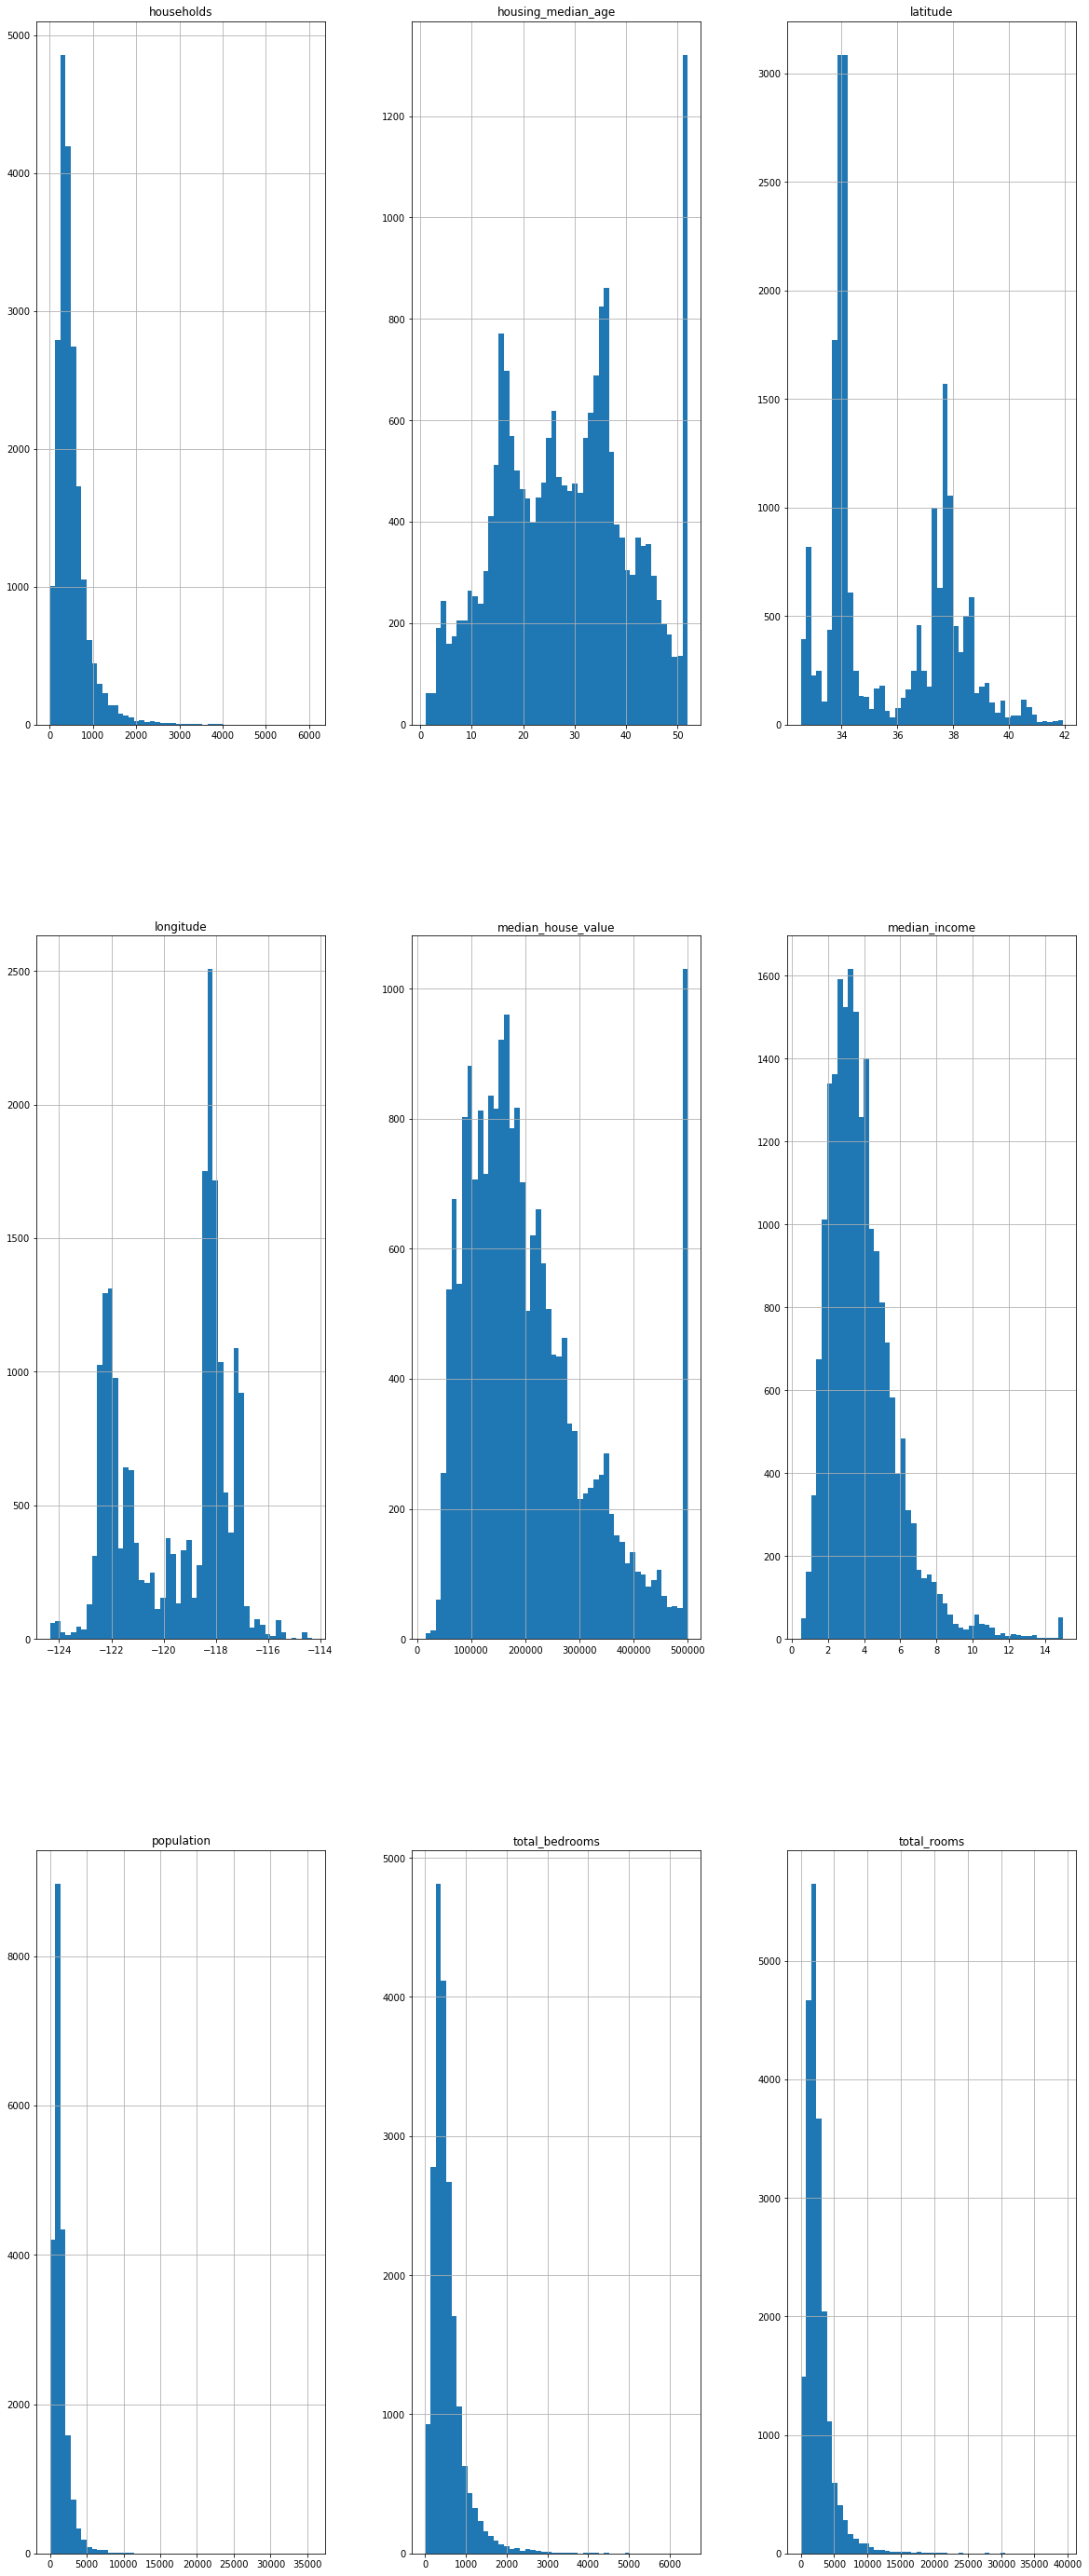

In [6]:
housing.hist(bins=50, figsize=(20, 50))
plt.show()

In [7]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_size = int(len(data) * test_ratio)
    test_idx = shuffled_indices[:test_size]
    train_idx = shuffled_indices[test_size:]
    return data.iloc[train_idx], data.iloc[test_idx]

In [8]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [9]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')

In [10]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [11]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [12]:
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    start_train_set = housing.loc[train_index]
    start_test_set = housing.loc[test_index]

In [14]:
housing.income_cat.value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [15]:
for set_ in (start_train_set, start_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

In [16]:
housing = start_train_set.copy()

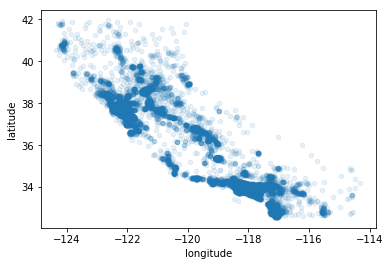

In [17]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

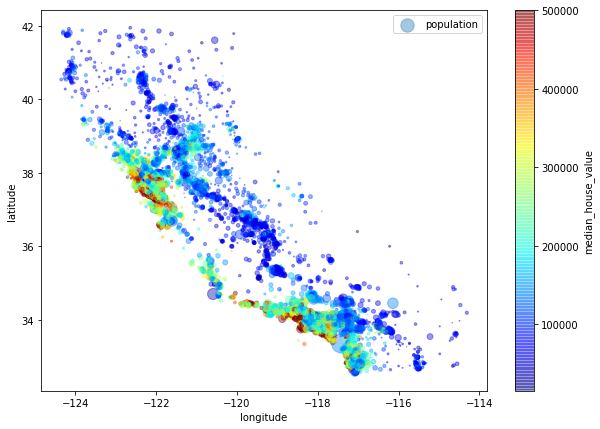

In [18]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
            s=housing['population']/100, label='population', figsize=(10, 7),
            c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True, sharex=False)
plt.legend()

In [19]:
corr_matrix = housing.corr()

In [20]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

In [21]:
from pandas.plotting import scatter_matrix

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11bdbbe48>,
      dtype=object)

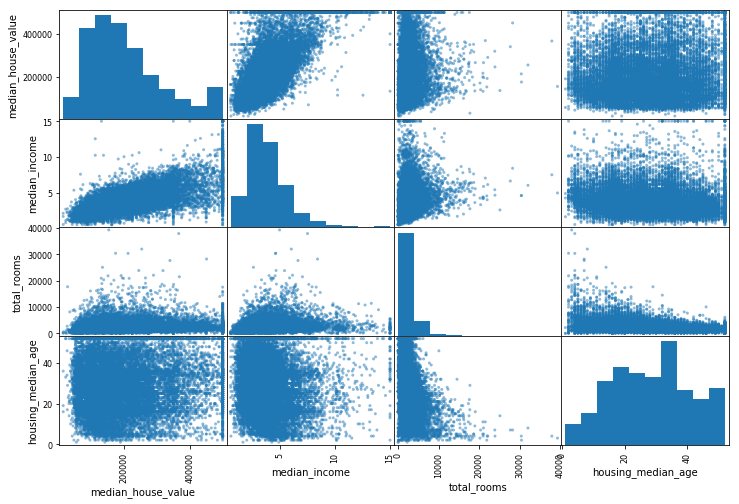

In [22]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12, 8))

In [23]:
housing['room_per_houshold'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_houshold'] = housing['population'] / housing['households']

In [24]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value         1.000000
median_income              0.687160
room_per_houshold          0.146285
total_rooms                0.135097
housing_median_age         0.114110
households                 0.064506
total_bedrooms             0.047689
population_per_houshold   -0.021985
population                -0.026920
longitude                 -0.047432
latitude                  -0.142724
bedrooms_per_room         -0.259984
Name: median_house_value, dtype: float64

In [25]:
housing = start_train_set.drop('median_house_value', axis=1)
housing_label = start_train_set['median_house_value'].copy()

In [26]:
# sklearn imputation lib
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='median')
housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [27]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [28]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [29]:
X = imputer.transform(housing_num)

In [30]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=list(housing.index.values))

In [31]:
housing_cat = housing['ocean_proximity']
housing_cat.head()

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
Name: ocean_proximity, dtype: object

In [32]:
pd.unique(housing_cat)

array(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'],
      dtype=object)

In [33]:
housing_cat_encoded, housing_categories = housing_cat.factorize()
housing_cat_encoded[:10]

array([0, 0, 1, 2, 0, 2, 0, 2, 0, 0])

In [34]:
housing_categories

Index(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'], dtype='object')

In [35]:
# One-Hot encoding
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))

In [36]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [37]:
# [PR #9151](https://github.com/scikit-learn/scikit-learn/pull/9151)에서 가져온 CategoricalEncoder 클래스의 정의.
# 이 클래스는 사이킷런 0.20에 포함될 예정입니다.

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [38]:
# from sklearn.preprocessing import CategoricalEncoder # 추가 예정
# Sparse Vecotr 출력
cat_encoder = CategoricalEncoder()
housing_cat_reshaped = housing_cat.values.reshape(-1, 1)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [39]:
# Densy Vector 출력
cat_encoder = CategoricalEncoder(encoding='onehot-dense')
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [40]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [41]:
# 데이터 파라미터 생성 자동화 코드
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [42]:
# 파이프라인 구축
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imuter', Imputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [43]:
# 판다스 처리하는 파이프라인 구축
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [44]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imuter', Imputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', CategoricalEncoder(encoding='onehot-dense')),
])

In [45]:
# merge numeric pipeline & categorical pipeline

from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

In [46]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [47]:
housing_prepared.shape

(16512, 16)

### Linear Regression

In [48]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_label)

/Users/jinhong/miniconda3/envs/handson/lib/python3.5/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [49]:
sample_data = housing.iloc[:5]
sample_label = housing_label.iloc[:5]
sample_prepared = full_pipeline.transform(sample_data)

print('predict: ', lin_reg.predict(sample_prepared))
print('real: ', list(sample_label))


predict:  [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849878]
real:  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [50]:
# error rate 
from sklearn.metrics import mean_squared_error
housing_pred = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_label, housing_pred)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

### DecisionTree

In [51]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_label)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [52]:
housing_pred = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_label, housing_pred)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [53]:
# 10-fold cv
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_label, scoring='neg_mean_squared_error',
                        cv=10)
tree_rmse_score = np.sqrt(-scores)

In [54]:
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())
    

In [55]:
print('Decision Tree')
display_scores(tree_rmse_score)

print('='*80)
print('Linear Regression')
lin_score = cross_val_score(lin_reg, housing_prepared, housing_label, scoring='neg_mean_squared_error',
                        cv=10)
lin_rmse_scores = np.sqrt(-lin_score)
display_scores(lin_rmse_scores)

Decision Tree
Scores: [68989.17078961 67353.2927291  72046.13045925 67464.75677405
 70767.84803231 74577.21681913 71536.18034028 69909.55436015
 76599.61543532 70744.64548712]
Mean: 70998.84112263206
Standard deviation: 2769.152630608177
Linear Regression
Scores: [66782.73843989 66960.118071   70361.18285107 74742.02420674
 68022.09224176 71193.07033936 64969.63056405 68276.69992785
 71543.69797334 67665.10082067]
Mean: 69051.63554357362
Standard deviation: 2732.3913087537303


### Random Forest

In [56]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_label)

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_label, scoring='neg_mean_squared_error',
                        cv=10)
forest_rmse_score = np.sqrt(-forest_scores)

display_scores(forest_rmse_score)

Scores: [51346.66826979 50905.72074209 51890.78937256 54408.71270668
 52185.2050431  56354.20420166 50631.72273142 50334.94878001
 54889.45066929 52957.91290441]
Mean: 52590.53354209954
Standard deviation: 1919.7736938065063


In [57]:
housing_pred = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_label, housing_pred)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

22502.13064400747

## Hpyerparams tuning

In [58]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators':[3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)

grid_search.fit(housing_prepared, housing_label)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_features': [2, 4, 6, 8], 'n_estimators': [3, 10, 30]}, {'bootstrap': [False], 'max_features': [2, 3, 4], 'n_estimators': [3, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [59]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [60]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [62]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.98793677e-02, 7.06788710e-02, 4.41597833e-02, 1.88022162e-02,
       1.67521697e-02, 1.78026241e-02, 1.56006946e-02, 3.24840246e-01,
       6.60235587e-02, 1.08989781e-01, 7.56746312e-02, 1.50777586e-02,
       1.37380162e-01, 3.30233583e-05, 2.85027897e-03, 5.45483308e-03])

In [71]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3248402463767371, 'median_income'),
 (0.13738016178753043, 'INLAND'),
 (0.10898978129414989, 'pop_per_hhold'),
 (0.07987936772740789, 'longitude'),
 (0.07567463119429849, 'bedrooms_per_room'),
 (0.07067887096851959, 'latitude'),
 (0.0660235587281062, 'rooms_per_hhold'),
 (0.04415978331452504, 'housing_median_age'),
 (0.01880221622000583, 'total_rooms'),
 (0.01780262414101369, 'population'),
 (0.01675216968192635, 'total_bedrooms'),
 (0.015600694579242548, 'households'),
 (0.015077758584572389, '<1H OCEAN'),
 (0.005454833078371395, 'NEAR OCEAN'),
 (0.0028502789652452357, 'NEAR BAY'),
 (3.302335834790957e-05, 'ISLAND')]

## Evaluation with Test Data

In [75]:
final_model = grid_search.best_estimator_

X_test = start_test_set.drop('median_house_value', axis=1)
y_test = start_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, predictions)
final_rmse = np.sqrt(final_mse)

In [76]:
final_rmse

47880.26423759858

## Practice

In [82]:
from sklearn.svm import SVR
svr_reg = SVR()
params = [{'kernel':['linear'], 'C': [1, 5, 10, 30]},
         {'kernel': ['rbf'], 'C': [5, 50, 100], 'gamma': [0.01, 0.5, 1, 3]}]

svr_grid = GridSearchCV(svr_reg, params, cv=5,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)

In [83]:
svr_grid.fit(housing_prepared, housing_label)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [1, 5, 10, 30], 'kernel': ['linear']}, {'C': [5, 50, 100], 'kernel': ['rbf'], 'gamma': [0.01, 0.5, 1, 3]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [84]:
svr_grid.best_params_

{'C': 30, 'kernel': 'linear'}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
svr_random_grid = RandomizedSearchCV()